In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio as im
from sklearn.model_selection import train_test_split
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [2]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

In [3]:
#carregar os dados dos arquivos CSV
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
#Separar features (X) e labels (y) no conjunto de treino 
X_train = train_data.drop('label', axis = 1).values
y_train = train_data['label'].values

In [5]:
#o conjunto de testes não tem labels
X_test = test_data.values

In [6]:
#normalizar os pixeis para um intervalo entre 0 e 1 
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
#aplica reshape para deixar todos os dados no mesmo formato: 28x28 com uma escala de cor
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [8]:
y_train = to_categorical(y_train, num_classes = 10)

In [9]:
#configurando o modelo 
model = Sequential()

#primeiro passo: configurando a primeira camada de convolução, configurando o tipo de input e efetuando o MaxPooling 
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

#segundo passo: configurando a segunda camada de convolução e efetuando o MaxPooling
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#terceiro passo: configurando o Flatten para converter a matriz 2D em um vetor 1D
model.add(Flatten())

#quarto passo: camada totalmente conectada 
model.add(Dense(128, activation='relu'))

#quinto passo: "desliga" aleatoriamente metadade dos neurônios 
model.add(Dropout(0.5))

#sexto passo: camada de saída 
model.add(Dense(10, activation='softmax'))

#sétimo passo: compilar o modelo
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
#callback para salvar os melhores pesos durante o treinamento 
checkpoint = ModelCheckpoint(
    'melhor_modelo.keras',  #nome do arquivo onde os pesos serão salvo 
    monitor='val_accuracy',  #define a métrica a ser monitorada: acurácia 
    save_best_only=True,  #salva o melhor modelo 
    mode='max',  #modo 'max' pois queremos maximizar a acurácia 
    verbose=1  #mostra mensagens durante o treinamento 
)

In [11]:
#configurando o Early Stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss', #monitora a perda no conjunto de validação
    patience = 5, #espera 5 épocas sem melhoria antes de parar o treinament 
    restore_best_weights = True #restaura para os melhores pesos 
)

In [12]:
# Separar 20% dos dados de treino para validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Aplicar o ImageDataGenerator aos dados de treino e validação
train_generator = datagen.flow(X_train, y_train, batch_size=128)
val_generator = datagen.flow(X_val, y_val, batch_size=128)

In [13]:
#treinando o modelo com o callback 
history = model.fit(
    train_generator, 
    epochs = 20,  #número de épocas 
    validation_data = val_generator,
    callbacks=[checkpoint, early_stopping]  #adiciona o callback ao treinamento 
)

Epoch 1/20


261/263 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.6470
Epoch 1: val_accuracy improved from -inf to 0.84702, saving model to melhor_modelo.keras
263/263 [==============================] - 6s 21ms/step - loss: 1.0354 - accuracy: 0.6476 - val_loss: 0.4691 - val_accuracy: 0.8470
Epoch 2/20
261/263 [============================>.] - ETA: 0s - loss: 0.5351 - accuracy: 0.8236
Epoch 2: val_accuracy improved from 0.84702 to 0.90048, saving model to melhor_modelo.keras
263/263 [==============================] - 5s 20ms/step - loss: 0.5339 - accuracy: 0.8240 - val_loss: 0.3093 - val_accuracy: 0.9005
Epoch 3/20
263/263 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8695
Epoch 3: val_accuracy improved from 0.90048 to 0.92631, saving model to melhor_modelo.keras
263/263 [==============================] - 6s 21ms/step - loss: 0.4144 - accuracy: 0.8695 - val_loss: 0.2424 - val_accuracy: 0.9263
Epoch 4/20
261/263 [=====================

In [14]:
# Avaliar o modelo no conjunto de validação
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Acurácia no conjunto de validação: {val_accuracy:.4f}")

263/263 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.9857
Acurácia no conjunto de validação: 0.9857


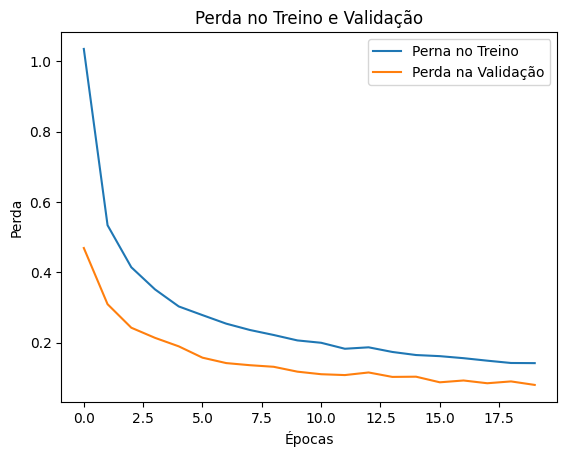

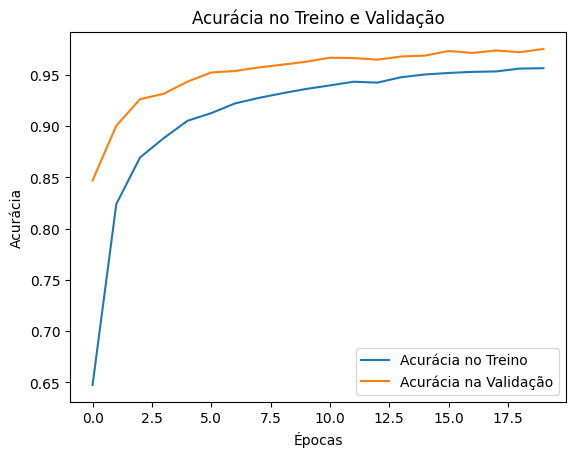

In [15]:
#avaliçaõ gráfica do modelo: perda
plt.plot(history.history['loss'], label='Perna no Treino')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Perda no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

#avaliçaõ gráfica do modelo: acurácia
plt.plot(history.history['accuracy'], label='Acurácia no Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Acurácia no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [16]:
#carrega o modelo que foi treinado 
model.load_weights('melhor_modelo.h5')

In [17]:
# Realizar predições
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

output = pd.DataFrame({'ImageId': range(1, len(predicted_labels) + 1), 'Label': predicted_labels})
output.to_csv('predictions.csv', index=False)

print("Predições salvas em 'predictions.csv'")

875/875 [==============================] - 1s 2ms/step
Predições salvas em 'predictions.csv'


In [27]:
import pandas as pd

# Carregar o arquivo test.csv
test_data = pd.read_csv('test.csv')

# Selecionar as primeiras N linhas (por exemplo, N = 10)
N = 35
new_data = test_data.head(N)

# Salvar como new_data.csv
new_data.to_csv('new_data.csv', index=False)

print(f"Arquivo 'new_data.csv' criado com as primeiras {N} linhas do 'test.csv'.")

Arquivo 'new_data.csv' criado com as primeiras 35 linhas do 'test.csv'.


In [28]:
# Carregar os novos dados
new_data = pd.read_csv('new_data.csv')

# Normalizar os dados (escala de 0 a 1)
new_data = new_data / 255.0

# Reshape dos dados para o formato (28, 28, 1)
new_data = new_data.values.reshape(-1, 28, 28, 1)

In [29]:
# Fazer a predição
predictions = model.predict(new_data)

# Converter as predições em labels (classes)
predicted_labels = np.argmax(predictions, axis=1)

# Exibir as predições
print("Labels preditos:", predicted_labels)

2/2 [==============================] - 0s 3ms/step
Labels preditos: [2 0 9 9 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6]


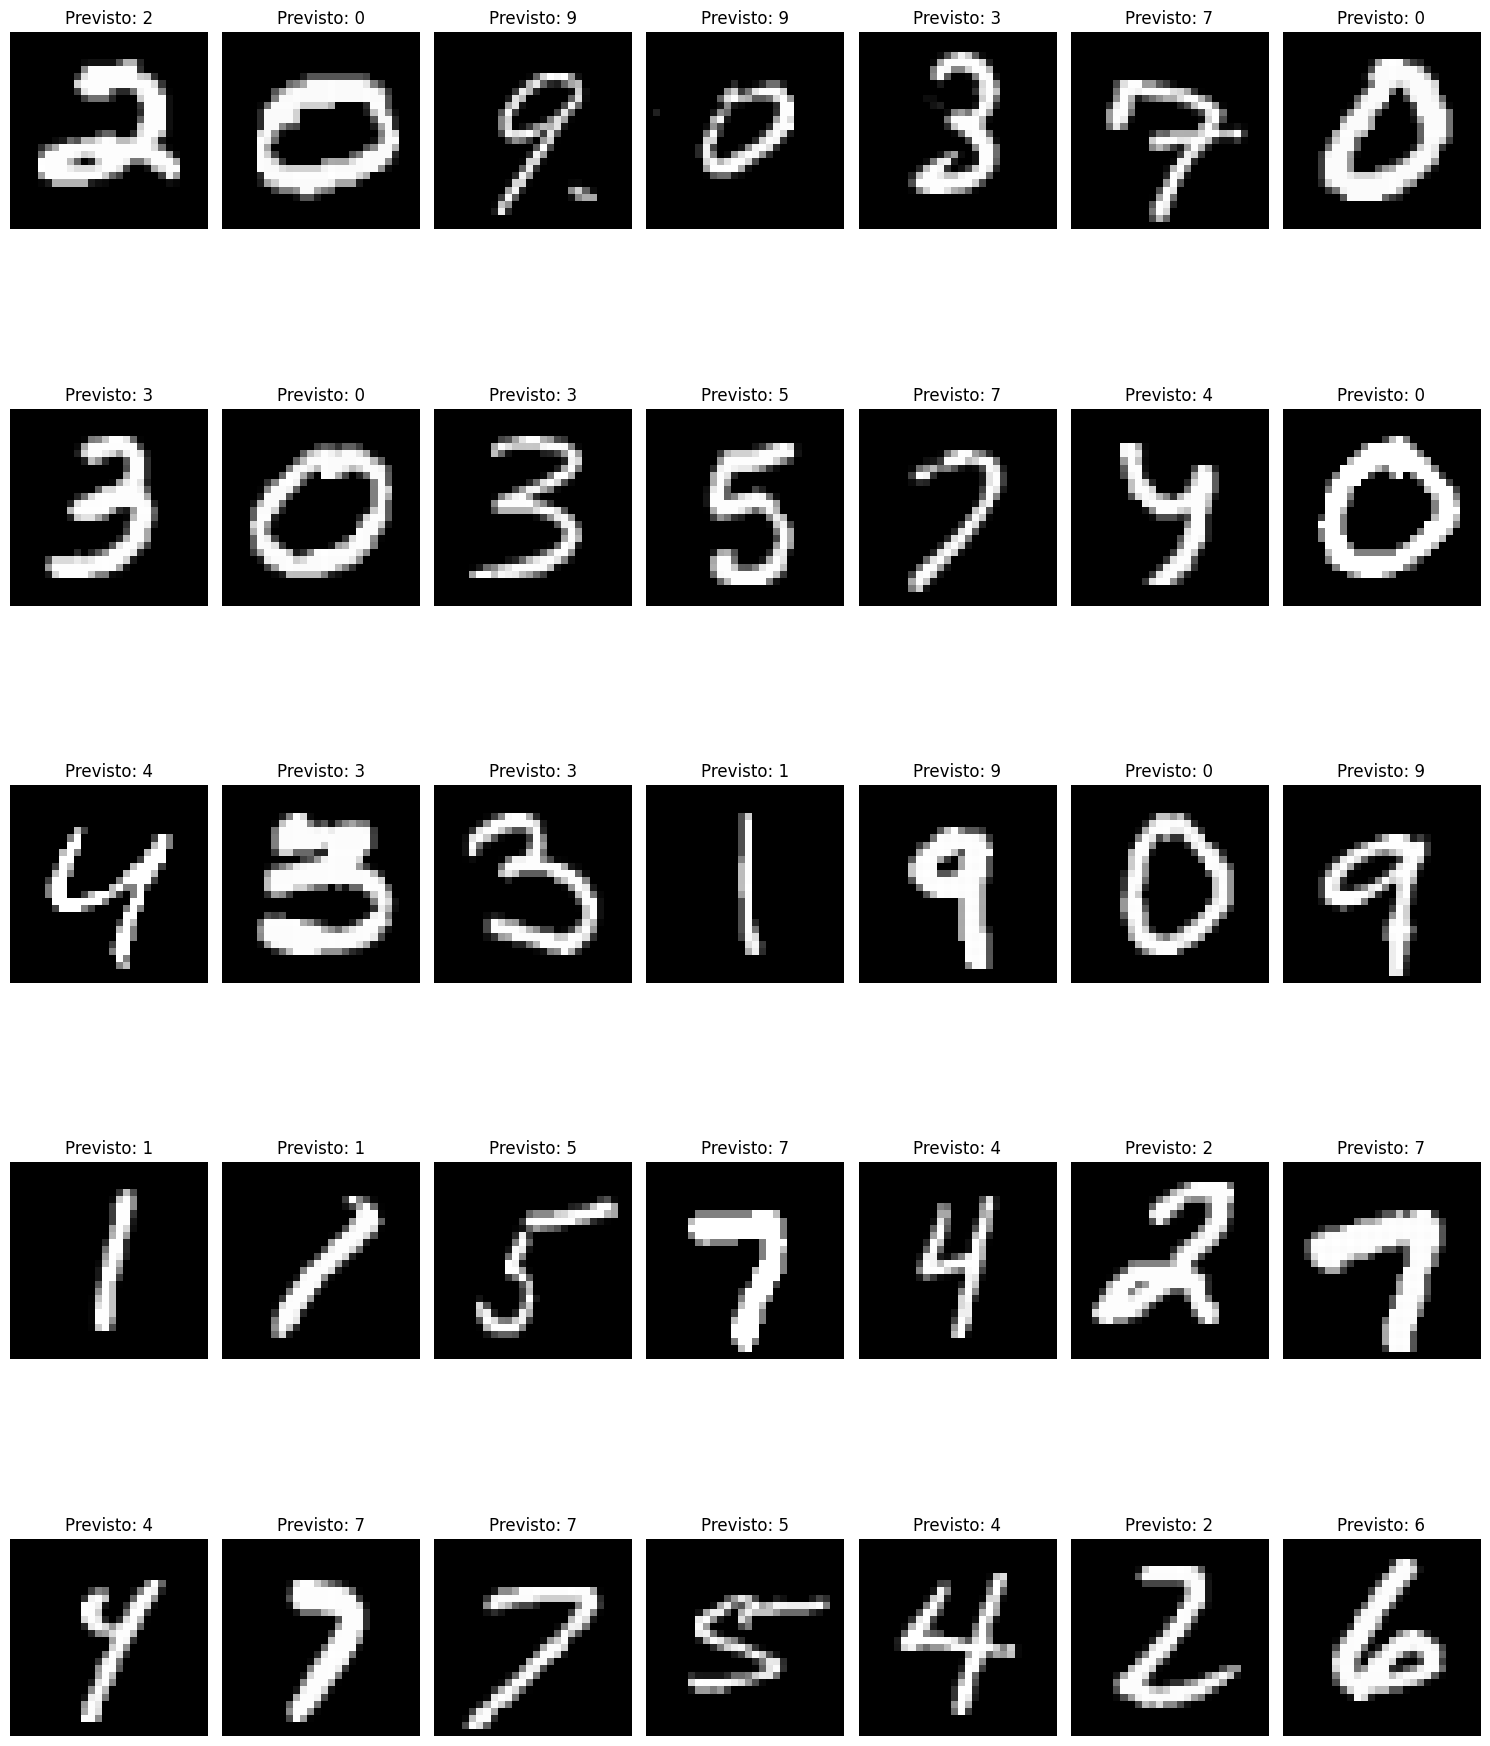

In [30]:
# Definir o número de imagens a serem exibidas
num_images_to_show = min(35, len(predicted_labels))  # Não exceder o tamanho de predicted_labels
num_rows = 5  # Número de linhas na grade
num_cols = 7  # Número de colunas na grade

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 20))

# Exibir as imagens e as previsões
for i in range(num_images_to_show):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Previsto: {predicted_labels[i]}")
    plt.axis('off')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 40ms/step
Visualizando ativações da camada: conv2d_1
Formato da ativação: (1, 26, 26, 32)


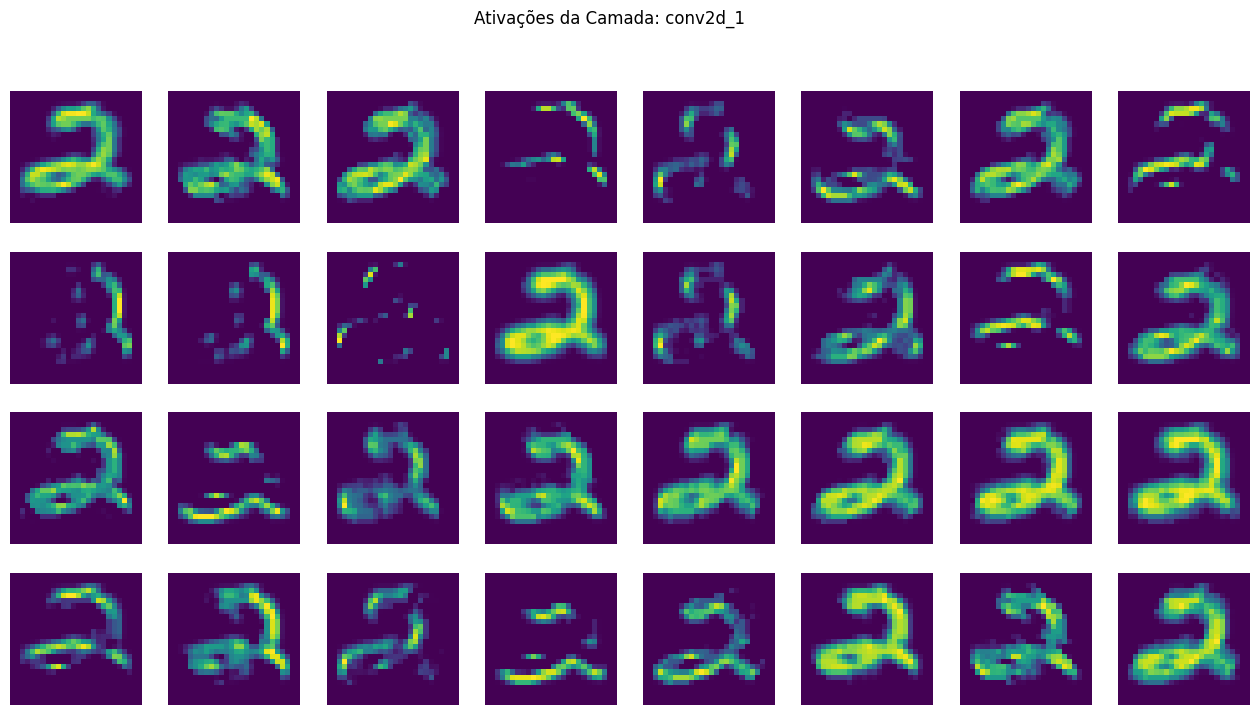

Visualizando ativações da camada: maxpooling2d_1
Formato da ativação: (1, 13, 13, 32)


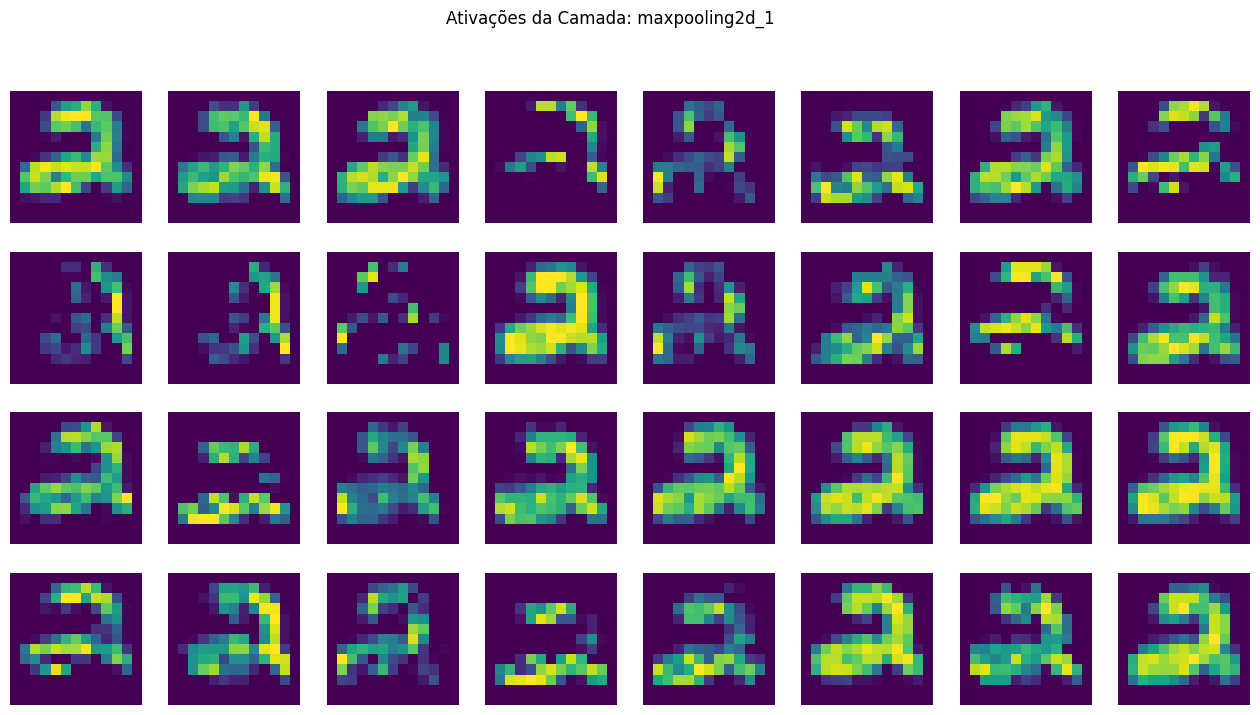

Visualizando ativações da camada: conv2d_2
Formato da ativação: (1, 11, 11, 64)


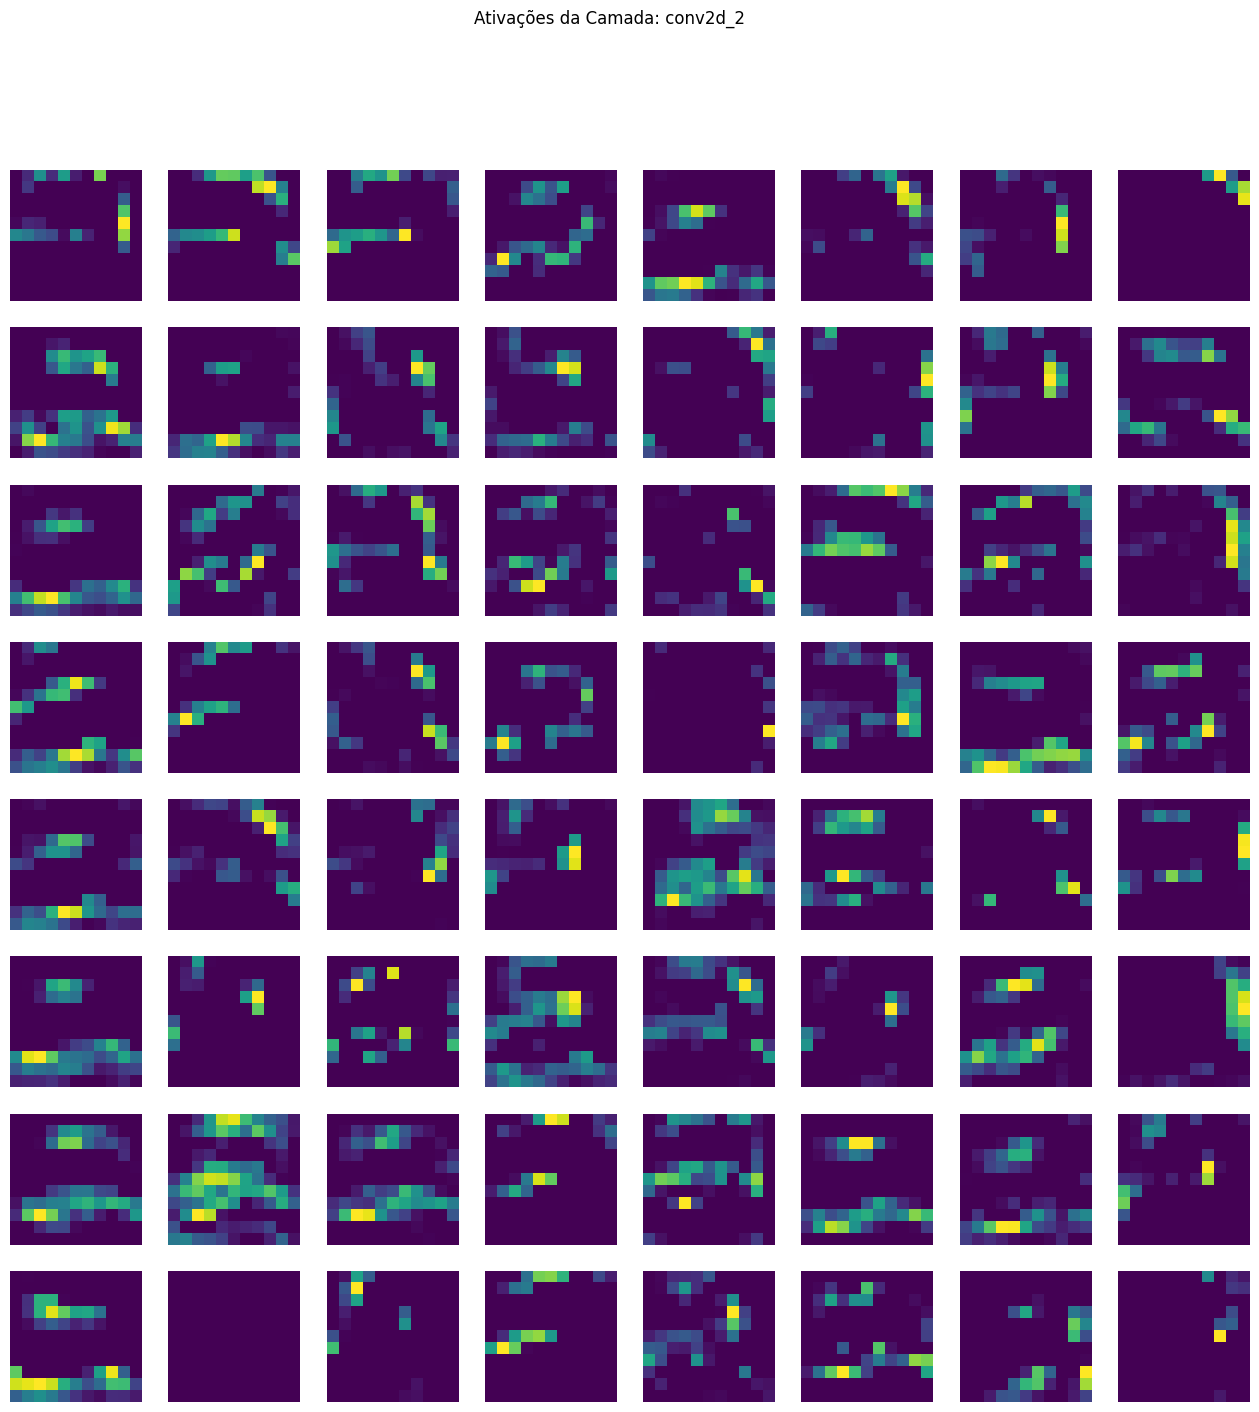

Visualizando ativações da camada: maxpooling2d_2
Formato da ativação: (1, 5, 5, 64)


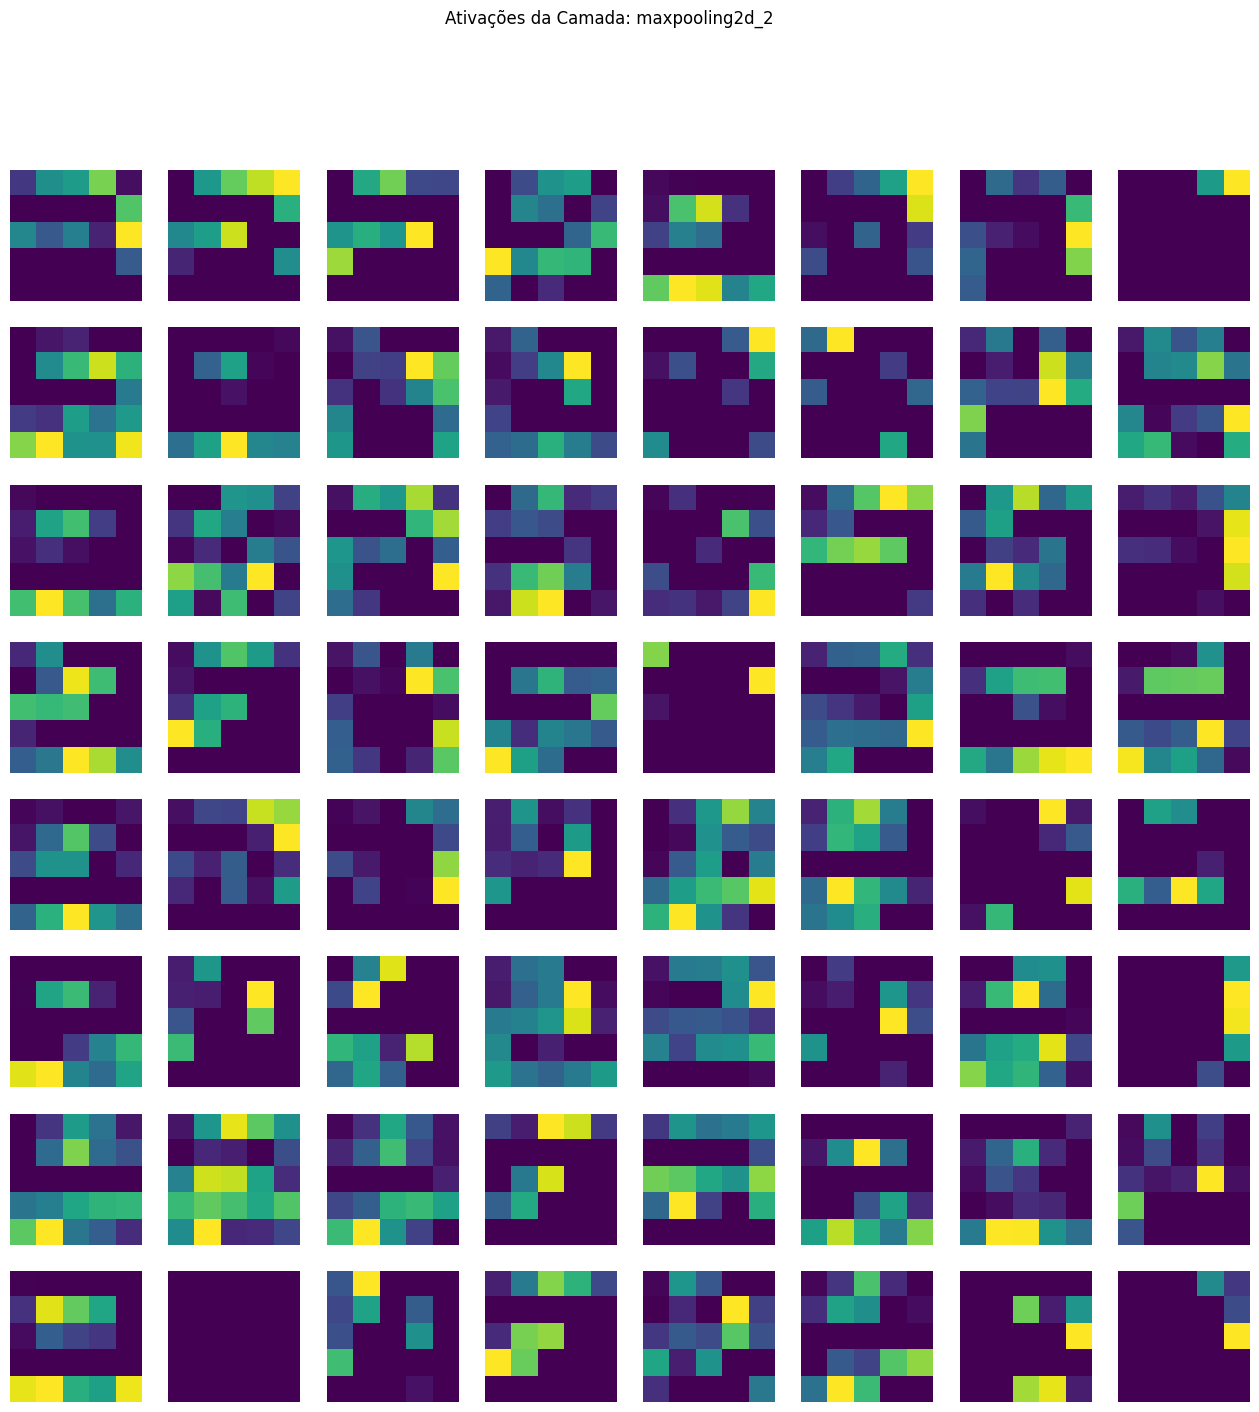

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Passo 1: Carregar o modelo e os pesos salvos
model = Sequential()

# Reconstruir a arquitetura do modelo com camadas nomeadas
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name='conv2d_1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpooling2d_1'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpooling2d_2'))
model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', name='dense_1'))
model.add(Dropout(0.5, name='dropout'))
model.add(Dense(10, activation='softmax', name='output'))

# Carregar os pesos salvos
model.load_weights('best_weights.h5')

# Compilar o modelo (isso inicializa o modelo)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Passo 2: Criar o modelo de ativação
# Extrair as saídas das camadas convolucionais e de pooling
layer_outputs = [layer.output for layer in model.layers[:4]]  # Pegar as saídas das primeiras 4 camadas
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Passo 3: Carregar uma imagem de exemplo (do new_data.csv)
new_data = pd.read_csv('new_data.csv')
image = new_data.iloc[0].values  # Pegar a primeira imagem
image = image.reshape(1, 28, 28, 1)  # Reshape para o formato (1, 28, 28, 1)

# Passo 4: Obter as ativações
activations = activation_model.predict(image)

# Passo 5: Visualizar as ativações
def display_activation(activations, layer_index, cols=8):
    """
    Função para exibir as ativações de uma camada específica.
    """
    activation = activations[layer_index]
    print(f"Formato da ativação: {activation.shape}")
    
    # Número de filtros na camada
    num_filters = activation.shape[-1]
    rows = num_filters // cols  # Número de linhas no grid
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    for row in range(rows):
        for col in range(cols):
            filter_index = row * cols + col
            if filter_index < num_filters:  # Verificar se o índice do filtro é válido
                axs[row, col].imshow(activation[0, :, :, filter_index], cmap='viridis')
            axs[row, col].axis('off')
    
    plt.suptitle(f'Ativações da Camada: {model.layers[layer_index].name}')
    plt.show()

# Exibir as ativações de cada camada
for i, activation in enumerate(activations):
    layer_name = model.layers[i].name
    print(f"Visualizando ativações da camada: {layer_name}")
    display_activation(activations, i)